In [146]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow import keras
from sklearn.metrics import log_loss, accuracy_score

import matplotlib.pyplot as plt

In [102]:
test_years = [
    '201617', '201718','201819'
]
train_years = [
    '200001','200102', '200203', '200304', '200405', '200506', '200607', '200708', '200809', '200910',
    '201011', '201112', '201213','201314', '201415','201516'
]
selected = 1

# private method used in sortAllGamesBySeed
def swap(row):   
    d = {
        'season': [row.pop('season')],
        'teamAName': [row.pop('teamBName')],
        'teamASeed': [row.pop('teamBSeed')],
        'teamBName': [row.pop('teamAName')],
        'teamBSeed': [row.pop('teamASeed')],
    }
    updated_row = pd.DataFrame(data=d)
    return updated_row
    
# left = higherSeed, right = lowerSeed
def sortAllGamesBySeed(year):
    playoff_data = pd.read_csv("./data/playoff/playoffdata" + year + ".csv")

    ## Swap columns so higher seed (lower value) on the left, lower seed (higher value) on the right
    updated_data = playoff_data.copy()
    updated_data.columns = ['season', 'teamAName', 'teamASeed', 'teamBName', 'teamBSeed']
    for index, row in updated_data.iterrows():
        if row['teamASeed'] > row['teamBSeed']:
            updated_data.loc[index,['teamAName', 'teamBName']] = updated_data.loc[index,['teamBName', 'teamAName']].values
            updated_data.loc[index,['teamASeed', 'teamBSeed']] = updated_data.loc[index,['teamBSeed', 'teamASeed']].values
    return updated_data


# break down the bracket into rounds
def breakdownBracket(updated_data):
    first_round = None
    second_round = None
    third_round = None
    fourth_round = None
    semi_final = updated_data.iloc[60 : 62]
    final = updated_data.iloc[62 : 63]
    for region_index in range(0, 60, 15): 
        first = updated_data.iloc[region_index : region_index + 8]
        first_round = first if first_round is None else pd.concat([first_round, first])

        second = updated_data.iloc[region_index + 8 : region_index + 12, :]  
        second_round = second if second_round is None else pd.concat([second_round, second])

        third = updated_data.iloc[region_index + 12 : region_index + 14]
        third_round = third if third_round is None else pd.concat([third_round, third])

        fourth = updated_data.iloc[region_index + 14 : region_index + 15]
        fourth_round = fourth if fourth_round is None else pd.concat([fourth_round, fourth])
    return first_round, second_round, third_round, fourth_round, semi_final, final


def swapGames(playoff_data):
#     playoff_data = pd.read_csv("./data/playoff/playoffdata" + year + ".csv")

    ## Swap columns so higher seed (lower value) on the left, lower seed (higher value) on the right
    updated_data = playoff_data.copy()
    updated_data.columns = ['season', 'teamAName', 'teamASeed', 'teamBName', 'teamBSeed']
    for index, row in updated_data.iterrows():
        if row['teamASeed'] > row['teamBSeed']:
            updated_data.loc[index,['teamAName', 'teamBName']] = updated_data.loc[index,['teamBName', 'teamAName']].values
            updated_data.loc[index,['teamASeed', 'teamBSeed']] = updated_data.loc[index,['teamBSeed', 'teamASeed']].values
    return updated_data

def calculateLabels(year, games):
    playoff_results = pd.read_csv("./data/playoff/playoffdata" + year + ".csv")
    winner_names = playoff_results['winnerName']
    labels = winner_names.copy()
    for index, row in games.iterrows():
        if row['teamAName'] == winner_names.loc[index]:
            labels.loc[index] = 1
        else:
            labels.loc[index] = 0
    return labels.to_frame()


def compareTeams(team_a_info, team_b_info):
    if len(team_a_info.columns) == len(team_b_info.columns):
        diff = team_a_info.copy()
        for col in team_a_info.columns:
            diff[col] = team_a_info[col].values - team_b_info[col].values
        return diff
    else: 
        print("Team A column length: ", len(team_A.columns))
        print("Team B column length: ", len(team_B.columns))
        print("Something is wrong in the data")
        return None

    # find difference between two teams' stats
def compareTeamsByName(teamAName, teamBName, year):
    team_A = getTeamDataByYear(year, teamAName)
    team_B = getTeamDataByYear(year, teamBName)
    if len(team_A.columns) == len(team_B.columns):
        diff = team_A.copy()
        for col in team_A.columns:
            diff[col] = team_A[col].values[0] - team_B[col].values[0]
        return diff
    else: 
        print("Team A column length: ", len(team_A.columns))
        print("Team B column length: ", len(team_B.columns))
        print("Something is wrong in the data")
        return None

def getTeamInfos(teamA, teamB, year):
    data = pd.read_excel(io="./data/formatted/basic/basicdata" + year + ".xlsx")
    team_basic_data = data.copy()
    
    team_a = teamA.copy()
    team_b = teamB.copy()

    team_a = team_a.merge(team_basic_data, left_on='teamAName', right_on='School', how='left')
    team_a = team_a.rename(columns={"teamASeed": "seed"})
    team_a.drop('teamAName', axis=1, inplace=True)
#     team_a.drop('teamASeed', axis=1, inplace=True)
    team_a.drop('School', axis=1, inplace=True)
    team_a.drop('ID', axis=1, inplace=True)
    team_a.drop('PersonalFouls', axis=1, inplace=True)

    team_b = team_b.merge(team_basic_data, left_on='teamBName', right_on='School', how='left')
    team_b = team_b.rename(columns={"teamBSeed": "seed"})
    team_b.drop('teamBName', axis=1, inplace=True)
#     team_b.drop('teamBSeed', axis=1, inplace=True)
    team_b.drop('School', axis=1, inplace=True)
    team_b.drop('ID', axis=1, inplace=True)
    team_b.drop('PersonalFouls', axis=1, inplace=True)
        
    return team_a, team_b
    
def getAllGames(years):
    all_games = None
    all_labels = None
    for year in years:
        data = pd.read_csv("./data/playoff/playoffdata" + year + ".csv")
        playoff_data = swapGames(data.copy())
        labels = calculateLabels(year, playoff_data)
        
        team_a = playoff_data.iloc[:, 1:3]
        team_b = playoff_data.iloc[:, 3:5]
        
        team_a, team_b = getTeamInfos(team_a, team_b, year)
        
        diff_games = compareTeams(team_a, team_b)
        
        all_labels = labels if all_labels is None else pd.concat([all_labels, labels])
        all_games = diff_games if all_games is None else pd.concat([all_games, diff_games])
    
    return all_games, all_labels


def normalizeData(data): 
    updated_data = data.copy()
    for col in data.columns:
        rows = data[col].values
        min_val = min(rows)
        rows = (rows + abs(min_val))
        updated_data.update(pd.DataFrame({col: rows}))
    return updated_data


def execute(model, x_train, y_train, x_test, y_test, epochs):
    mse = list()
    logloss = list()
    score = list()
    for i in range(epochs):
        model.fit(x_train, y_train['winnerName'].tolist())
        pred = model.predict(x_test)
        pred_proba = model.predict_proba(x_test)
        mse.append(mean_squared_error(y_test, pred))
        logloss.append(log_loss(y_test, pred_proba))
        score.append(model.score(x_test, y_test))
#     print("MSE: ", mse)
#     print("Log Loss for Proba: ", log_loss(y_test, pred_proba))
#     print("Score:", model.score(x_test, y_test))
#     print('----------------------------------------')
    return model, pred, mse, logloss, score


def findWinners(predicted_labels, games):
    team_a_names = games['teamAName'].values
    team_b_names = games['teamBName'].values
    team_a_seeds = games['teamASeed'].values
    team_b_seeds = games['teamBSeed'].values
    winners = list()
    seeds = list()
    for i in range(len(predicted_labels)):
        winner = predicted_labels[i]
        if winner == 1: 
            winners.append(team_a_names[i])
            seeds.append(team_a_seeds[i])
        elif winner == 0: 
            winners.append(team_b_names[i])
            seeds.append(team_b_seeds[i])
    return winners, seeds

def makeGames(players, seeds):
    if len(players) == 1: 
        pring("Champion is", players[0])
    elif len(players) % 2 != 0: 
        print("MISSING PLAYERS")
    else:
        team_a = list()
        team_a_seed = list()
        team_b = list()
        team_b_seed = list()
        for i in range(len(players)): 
            if i % 2 == 0:
                team_a.append(players[i])
                team_a_seed.append(seeds[i])
            else: 
                team_b.append(players[i])
                team_b_seed.append(seeds[i])
        games = pd.DataFrame({
            'teamAName': team_a,
            'teamASeed': team_a_seed, 
            'teamBName': team_b, 
            'teamBSeed': team_b_seed
        })
        return games

In [165]:
# Following https://www.tensorflow.org/tutorials/keras/classification

# getting training and testing data 
x_train, y_train = getAllGames(train_years)
x_test, y_test = getAllGames(test_years)


model = keras.Sequential([
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(64, activation='sigmoid'),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dense(2, activation='sigmoid'),
    keras.layers.Dense(1, activation='sigmoid'),
])

# More model setup - Set optimizer, loss function, and metrics for model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training model
# Convert np array to tensor array
tf_train_data = tf.convert_to_tensor(np.array(x_train), np.float32)
tf_train_out =  tf.convert_to_tensor(np.array(y_train), np.float32)

tf_test_data = tf.convert_to_tensor(np.array(x_test), np.float32)
tf_test_out =  tf.convert_to_tensor(np.array(y_test), np.float32)

# history is used to plot further down below
history = model.fit(tf_train_data,
                    tf_train_out, 
                    epochs=100)

# Evaluating Accuracy
test_loss, test_acc = model.evaluate(tf_test_data,  tf_test_out, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

Train on 1008 samples
Epoch 1/100
1008/1008 [==============================] - 1s 1ms/sample - loss: 0.6194 - accuracy: 0.7133
Epoch 2/100
1008/1008 [==============================] - 0s 118us/sample - loss: 0.5810 - accuracy: 0.7133
Epoch 3/100
1008/1008 [==============================] - 0s 122us/sample - loss: 0.5623 - accuracy: 0.7133
Epoch 4/100
1008/1008 [==============================] - 0s 123us/sample - loss: 0.5508 - accuracy: 0.7133
Epoch 5/100
1008/1008 [==============================] - 0s 132us/sample - loss: 0.5425 - accuracy: 0.7133
Epoch 6/100
1008/1008 [==============================] - 0s 177us/sample - loss: 0.5355 - accuracy: 0.7133
Epoch 7/100
1008/1008 [==============================] - 0s 139us/sample - loss: 0.5297 - accuracy: 0.7133
Epoch 8/100
1008/1008 [==============================] - 0s 125us/sample - loss: 0.5234 - accuracy: 0.7133
Epoch 9/100
1008/1008 [==============================] - 0s 111us/sample - loss: 0.5186 - accuracy: 0.7133
Epoch 10/100
1008

1008/1008 [==============================] - 0s 118us/sample - loss: 0.2118 - accuracy: 0.9425
Epoch 77/100
1008/1008 [==============================] - 0s 105us/sample - loss: 0.2034 - accuracy: 0.9484
Epoch 78/100
1008/1008 [==============================] - 0s 99us/sample - loss: 0.2080 - accuracy: 0.9435
Epoch 79/100
1008/1008 [==============================] - 0s 107us/sample - loss: 0.2056 - accuracy: 0.9464
Epoch 80/100
1008/1008 [==============================] - 0s 104us/sample - loss: 0.2074 - accuracy: 0.9484
Epoch 81/100
1008/1008 [==============================] - 0s 108us/sample - loss: 0.1990 - accuracy: 0.9474
Epoch 82/100
1008/1008 [==============================] - 0s 117us/sample - loss: 0.1976 - accuracy: 0.9494
Epoch 83/100
1008/1008 [==============================] - 0s 146us/sample - loss: 0.1841 - accuracy: 0.9544
Epoch 84/100
1008/1008 [==============================] - 0s 143us/sample - loss: 0.1783 - accuracy: 0.9603
Epoch 85/100
1008/1008 [==================

In [169]:
# Make predictions
# Need test data to make this work
predictions = model.predict(tf_test_data)
pred_labels = 1 - (np.argmax(predictions, axis=1))
# print('\nsklearn log loss:', log_loss(y_test, predictions))
# print('\nsklearn accuracy:', accuracy_score(y_test, pred_labels))

data = pd.read_csv("./data/playoff/playoffdata" + test_years[selected] + ".csv")
playoff_data = swapGames(data.copy())
games = breakdownBracket(playoff_data)[0]
winner_names, seeds = findWinners(pred_labels[:len(games)], games)

print("\n\nPREDICT")
print(winner_names)
print('------------------------------------')
while (len(winner_names) > 1):
    games = makeGames(winner_names, seeds)
    team_a, team_b = getTeamInfos(games.iloc[:, :2], games.iloc[:, 2:], test_years[selected])
    diff = compareTeams(team_a, team_b)
    tfdiff = tf.convert_to_tensor(np.array(diff), np.float32)
    pred = model.predict(tfdiff)
    pred_labels = 1 - (np.argmax(pred, axis=1))
    winner_names, seeds = findWinners(pred_labels, games)
    print(winner_names)
    print(len(winner_names))

    print('------------------------------------')



PREDICT
['Villanova', 'Virginia Tech', 'West Virginia', 'Wichita State', 'Florida', 'Texas Tech', 'Arkansas', 'Purdue', 'Kansas', 'Seton Hall', 'Clemson', 'Auburn', 'Texas Christian', 'Michigan State', 'Rhode Island', 'Duke', 'Xavier', 'Missouri', 'Ohio State', 'Gonzaga', 'Houston', 'Michigan', 'Texas A&M', 'North Carolina', 'Virginia', 'Creighton', 'Kentucky', 'Arizona', 'Miami (FL)', 'Tennessee', 'Nevada', 'Cincinnati']
------------------------------------
['Villanova', 'West Virginia', 'Florida', 'Arkansas', 'Kansas', 'Clemson', 'Texas Christian', 'Rhode Island', 'Xavier', 'Ohio State', 'Houston', 'Texas A&M', 'Virginia', 'Kentucky', 'Miami (FL)', 'Nevada']
16
------------------------------------
['Villanova', 'Florida', 'Kansas', 'Texas Christian', 'Xavier', 'Houston', 'Virginia', 'Miami (FL)']
8
------------------------------------
['Villanova', 'Kansas', 'Xavier', 'Virginia']
4
------------------------------------
['Villanova', 'Xavier']
2
------------------------------------
[

In [170]:
print("ACTUAL RESULT")
results = pd.read_csv("./data/playoff/playoffdata" + test_years[selected] + ".csv")
first, second, third, fourth, semi, final = breakdownBracket(results)
print(first['winnerName'].values)
print('----------')
print(second['winnerName'].values)
print('----------')
print(third['winnerName'].values)
print('----------')
print(fourth['winnerName'].values)
print('----------')
print(semi['winnerName'].values)
print('----------')
print(final['winnerName'].values)
print('----------')

ACTUAL RESULT
['Villanova' 'Alabama' 'West Virginia' 'Marshall' 'Florida' 'Texas Tech'
 'Butler' 'Purdue' 'Kansas' 'Seton Hall' 'Clemson' 'Auburn' 'Syracuse'
 'Michigan State' 'Rhode Island' 'Duke' 'Xavier' 'Florida State'
 'Ohio State' 'Gonzaga' 'Houston' 'Michigan' 'Texas A&M' 'North Carolina'
 'Maryland-Baltimore County' 'Kansas State' 'Kentucky' 'Buffalo'
 'Loyola (IL)' 'Tennessee' 'Nevada' 'Cincinnati']
----------
['Villanova' 'West Virginia' 'Texas Tech' 'Purdue' 'Kansas' 'Clemson'
 'Syracuse' 'Duke' 'Florida State' 'Gonzaga' 'Michigan' 'Texas A&M'
 'Kansas State' 'Kentucky' 'Loyola (IL)' 'Nevada']
----------
['Villanova' 'Texas Tech' 'Kansas' 'Duke' 'Florida State' 'Michigan'
 'Kansas State' 'Loyola (IL)']
----------
['Villanova' 'Kansas' 'Michigan' 'Loyola (IL)']
----------
['Villanova' 'Michigan']
----------
['Villanova']
----------


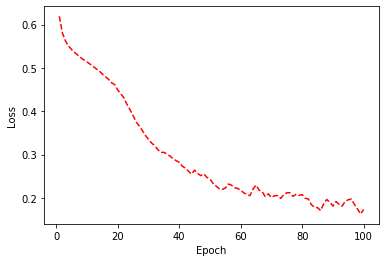

In [171]:
# Plotting

training_loss = history.history['loss']

# # Only plotting every 5 epochs
# training_loss = training_loss[::5]
# epoch_count = range(1, 101, 5)

epoch_count = range(1, 101)

plt.plot(epoch_count, training_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();